In [1]:
from corner import corner
import jax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from calibration.least_squares import least_squares, ChainStats

In [2]:
RANDOM_SUBSAMPLE = None

In [3]:
%%time
df = pd.read_csv('ps1_des-grizy.csv.bz2', engine='pyarrow')

if RANDOM_SUBSAMPLE is not None:
    df = df.sample(n=RANDOM_SUBSAMPLE, replace=False, random_state=0)

x = np.stack([df["des_mag_r"], df["des_mag_i"], df["ps1_mag_r"]], axis=1)
sigma2 = np.stack([df["des_magerr_r"], df["des_magerr_i"], df["ps1_magerr_r"]], axis=1)**2

r_ps1_des = df["ps1_mag_r"] - df["des_mag_r"]
ri_des = df["des_mag_r"] - df["des_mag_i"]

del df


print(f'{x.shape[0]} data points')

640646 data points
CPU times: user 6.53 s, sys: 345 ms, total: 6.87 s
Wall time: 6.08 s


In [4]:
%%time

states, ln_probs = least_squares(
    type='ordinal',
    x=x,
    sigma2=sigma2,
    initial_slopes=[1.139, -0.139, -1.0],
    initial_intercept=0.014,
    initial_dispersion=0.015,
    # slope1 = 1 + alpha
    # slope2 = -alpha
    # slope3 = -1
    ls_params_to_internal=lambda ls_param: jax.numpy.r_[-ls_param[1], ls_param[2], ls_param[3]],
    internal_params_to_ls=lambda internal: jax.numpy.r_[1.0 + internal[0], -internal[0], internal[1], internal[2]],
    # residual_fn=lambda x: jax.numpy.arctan(x),
    # ask dispersion to be not so large
    # ln_prior=lambda internal: HalfNormal(scale=0.001).log_prob(internal[-1]),
    num_samples=5_000,
    num_burnin=100,
    nuts_kwargs=dict(step_size=1e-5, unrolled_leapfrog_steps=3, parallel_iterations=1),
)

CPU times: user 9min 45s, sys: 11.5 s, total: 9min 57s
Wall time: 9min 37s


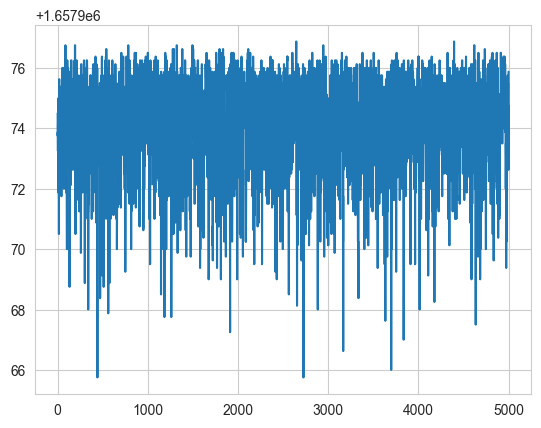

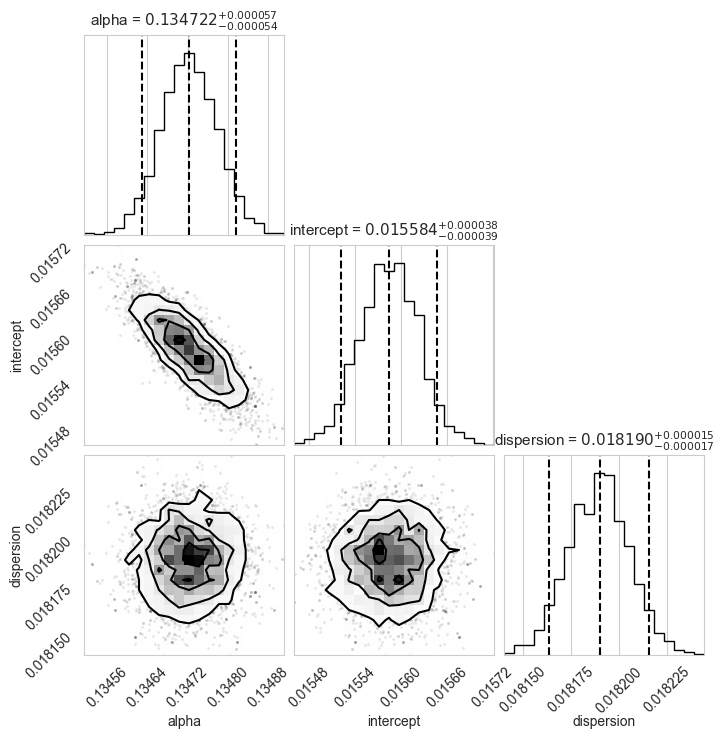

In [5]:
plt.figure()
plt.plot(ln_probs)

corner(
    data=np.asarray(states),
    labels=['alpha', 'intercept', 'dispersion'],
    quantiles=[0.05, 0.5, 0.95],
    show_titles=True,
    title_fmt='.6f',
    title_kwargs={"fontsize": 11},
)

stats = ChainStats.from_states(states)

Text(0.5, 0, 'PS1 r (data - model)')

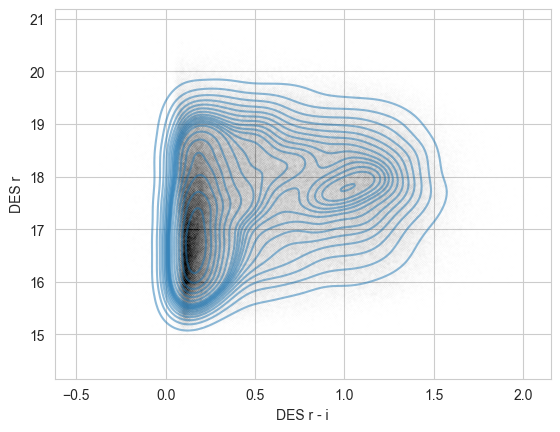

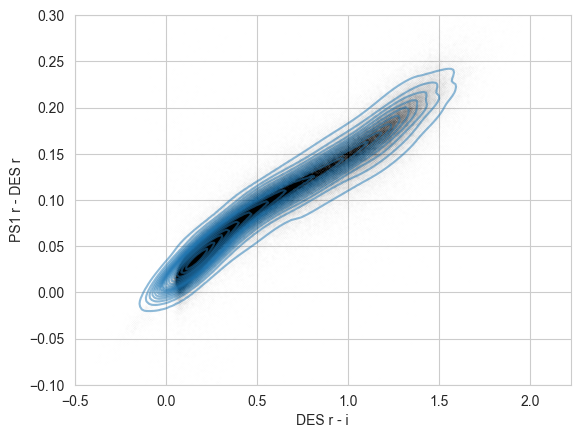

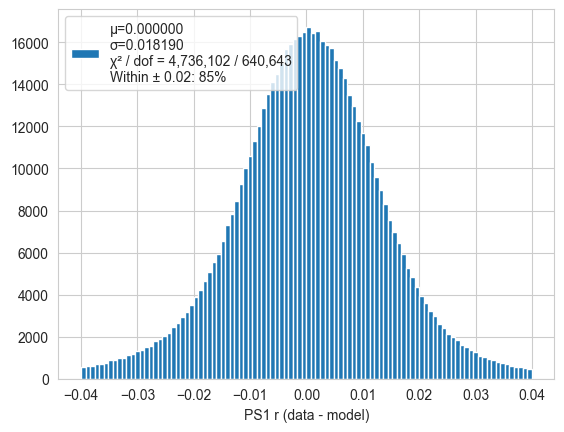

In [6]:
alpha, intercept, dispersion = stats.median

plt.figure()
n_kde = 10_000
idx = np.random.choice(len(ri_des), min(n_kde, len(ri_des)), replace=False)
sns.kdeplot(x=ri_des[idx], y=x[idx, 1], levels=20, alpha=0.5)
plt.scatter(ri_des, x[:, 1], color='k', s=0.05, alpha=0.01)
plt.xlabel('DES r - i')
plt.ylabel('DES r')

plt.figure()
n_kde = 10_000
idx = np.random.choice(len(ri_des), min(n_kde, len(ri_des)), replace=False)
sns.kdeplot(x=ri_des[idx], y=r_ps1_des[idx], levels=20, alpha=0.5)
plt.scatter(ri_des, r_ps1_des, color='k', s=0.05, alpha=0.01)
plt.ylim(-0.1, 0.3)
plt.xlabel('DES r - i')
plt.ylabel('PS1 r - DES r')

plt.figure()
residuals = r_ps1_des - (alpha * ri_des + intercept)
residuals_range = np.linspace(-0.04, 0.04, 100)
residuals_mu, residuals_sigma = np.mean(residuals), np.std(residuals, ddof=3)
residuals_chi2 = np.sum(residuals**2 / (sigma2 @ np.square([1 + alpha, -alpha, -1] + dispersion**2)))
plt.hist(residuals, bins=residuals_range.shape[0], range=[residuals_range[0], residuals_range[-1]],
         label=f'μ={residuals_mu:.6f}\nσ={residuals_sigma:.6f}\nχ² / dof = {int(residuals_chi2):,d} / {len(residuals) - 3:,d}\nWithin ± 0.02: {np.mean(np.abs(residuals) < 0.02) * 100:.0f}%')
plt.legend()
plt.xlabel('PS1 r (data - model)')